# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://course.cse.ust.hk/comp4901j/Password_Only/programs/assignment1/index.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [51]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

results = {}
best_val = -1
best_svm = None

learning_rates = [1e-3, 1e-4] # [2e-5, 1.2e-6]
regularization_strengths = [1e-2, 5e-3] # [2.5e4, 3e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

for lr in learning_rates:
    for re in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=re,
                  num_iters=1500, verbose=False)
        
        y_train_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
                     
        y_val_pred = svm.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        results[(lr, re)] = (train_accuracy, val_accuracy)
        
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-04 reg 5.000000e-03 train accuracy: 0.451327 val accuracy: 0.453000
lr 1.000000e-04 reg 1.000000e-02 train accuracy: 0.451163 val accuracy: 0.449000
lr 1.000000e-03 reg 5.000000e-03 train accuracy: 0.501592 val accuracy: 0.488000
lr 1.000000e-03 reg 1.000000e-02 train accuracy: 0.501776 val accuracy: 0.492000
best validation accuracy achieved during cross-validation: 0.492000


In [52]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.476


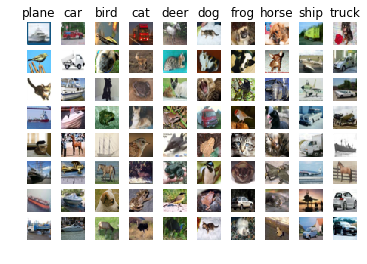

In [53]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

No, they do not. The results for some are seemingly random, as labels like plane are often misclassified while others such as truck, dog, and cat are more accurate in nature. You can see that planes and ships can be misclassfied due to the fact that both have blue-colored backgrounds, while cats and dogs exhibit similar features such as having 4 legs and a tail, which makes them be misclassified once in a while.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [54]:
print(X_train_feats.shape)

(49000, 155)


In [65]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
num_classes = 10
best_val = -1
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
np.random.seed(0) # reproducibility for inits
# hyperparams range is formatted by [LO : HI]
# where numbers between 
hidden_size_range = [10, 1000]
learning_rate_erange = [-1, 0]
regularization_strength_erange = [-7, -4]

for _ in range(30):
    # generate some values to attempt to find some good hyperparams
    # Refer to http://cs231n.github.io/neural-networks-3/#hyper
    hs = np.random.randint(hidden_size_range[0], hidden_size_range[1])
    lr = 10 ** np.random.uniform(learning_rate_erange[0], learning_rate_erange[1])
    re = 10 ** np.random.uniform(regularization_strength_erange[0], regularization_strength_erange[1])
    net = TwoLayerNet(input_dim, hs, num_classes)
            
    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=2000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=re, verbose=True)
            
    # print details of current run
    print('********************************')
    print('hs: %e lr: %e re: %e' % (hs, lr, re))
            
    train_acc = (net.predict(X_train_feats) == y_train).mean()
    print('Train accuracy: ', train_acc)
            
    # Predict on the validation set
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    print('Validation accuracy: ', val_acc)
    print('********************************')
            
    if val_acc > best_val:
        best_val = val_acc
        best_net = net
                     
print('Best validation accuracy obtained: ', best_val)
print('********************************')
    

    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 1.640321
iteration 200 / 2000: loss 1.398683
iteration 300 / 2000: loss 1.254376
iteration 400 / 2000: loss 1.485401
iteration 500 / 2000: loss 1.246927
iteration 600 / 2000: loss 1.227609
iteration 700 / 2000: loss 1.025196
iteration 800 / 2000: loss 1.254859
iteration 900 / 2000: loss 1.099849
iteration 1000 / 2000: loss 1.168194
iteration 1100 / 2000: loss 1.050344
iteration 1200 / 2000: loss 1.024272
iteration 1300 / 2000: loss 0.936503
iteration 1400 / 2000: loss 0.985581
iteration 1500 / 2000: loss 1.053554
iteration 1600 / 2000: loss 1.030197
iteration 1700 / 2000: loss 0.960774
iteration 1800 / 2000: loss 0.967417
iteration 1900 / 2000: loss 0.922778
********************************
hs: 6.940000e+02 lr: 3.916017e-01 re: 3.410337e-05
Train accuracy:  0.7105918367346938
Validation accuracy:  0.593
********************************
iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.289790
iteration 200 / 2000:

iteration 100 / 2000: loss 2.160316
iteration 200 / 2000: loss 1.589474
iteration 300 / 2000: loss 1.348895
iteration 400 / 2000: loss 1.344964
iteration 500 / 2000: loss 1.513804
iteration 600 / 2000: loss 1.288955
iteration 700 / 2000: loss 1.288898
iteration 800 / 2000: loss 1.300116
iteration 900 / 2000: loss 1.212349
iteration 1000 / 2000: loss 1.278527
iteration 1100 / 2000: loss 1.238435
iteration 1200 / 2000: loss 1.159517
iteration 1300 / 2000: loss 1.160949
iteration 1400 / 2000: loss 1.177652
iteration 1500 / 2000: loss 1.180114
iteration 1600 / 2000: loss 1.072948
iteration 1700 / 2000: loss 1.035526
iteration 1800 / 2000: loss 1.236042
iteration 1900 / 2000: loss 0.993372
********************************
hs: 2.600000e+02 lr: 2.121628e-01 re: 1.359462e-06
Train accuracy:  0.6264489795918368
Validation accuracy:  0.58
********************************
iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 1.535010
iteration 200 / 2000: loss 1.406586
iteration 300 / 2000

iteration 200 / 2000: loss 1.400963
iteration 300 / 2000: loss 1.345432
iteration 400 / 2000: loss 1.283708
iteration 500 / 2000: loss 1.169328
iteration 600 / 2000: loss 1.113796
iteration 700 / 2000: loss 1.241995
iteration 800 / 2000: loss 1.387218
iteration 900 / 2000: loss 1.094151
iteration 1000 / 2000: loss 1.157128
iteration 1100 / 2000: loss 1.002182
iteration 1200 / 2000: loss 1.044008
iteration 1300 / 2000: loss 1.208983
iteration 1400 / 2000: loss 0.932968
iteration 1500 / 2000: loss 1.015389
iteration 1600 / 2000: loss 1.005533
iteration 1700 / 2000: loss 1.006697
iteration 1800 / 2000: loss 1.100858
iteration 1900 / 2000: loss 1.026902
********************************
hs: 9.930000e+02 lr: 3.105094e-01 re: 5.322065e-07
Train accuracy:  0.6868775510204082
Validation accuracy:  0.589
********************************
iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 1.597645
iteration 200 / 2000: loss 1.315263
iteration 300 / 2000: loss 1.341251
iteration 400 / 200

iteration 300 / 2000: loss 1.319814
iteration 400 / 2000: loss 1.393573
iteration 500 / 2000: loss 1.283683
iteration 600 / 2000: loss 1.264229
iteration 700 / 2000: loss 1.354013
iteration 800 / 2000: loss 1.258958
iteration 900 / 2000: loss 1.172500
iteration 1000 / 2000: loss 1.138877
iteration 1100 / 2000: loss 1.200821
iteration 1200 / 2000: loss 1.022173
iteration 1300 / 2000: loss 1.230236
iteration 1400 / 2000: loss 1.136190
iteration 1500 / 2000: loss 1.193049
iteration 1600 / 2000: loss 0.984235
iteration 1700 / 2000: loss 1.061597
iteration 1800 / 2000: loss 1.166349
iteration 1900 / 2000: loss 1.063249
********************************
hs: 4.130000e+02 lr: 2.609567e-01 re: 1.692075e-05
Train accuracy:  0.6558367346938776
Validation accuracy:  0.587
********************************
iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.302286
iteration 200 / 2000: loss 2.105634
iteration 300 / 2000: loss 1.742172
iteration 400 / 2000: loss 1.461291
iteration 500 / 200

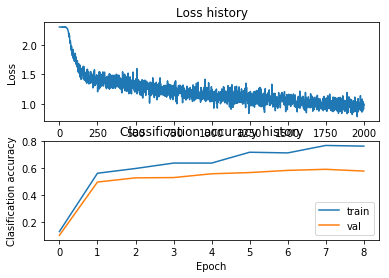

In [66]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

In [67]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.6


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!